# Logistic Regression

A few days ago I woke up and I thought about *Logistic Regression*. I wondered, when was the last time I went over it? When was the last time I ever thought about how it works?

It's one of the simplest (yet fastest in some ways) binary classification machine learning algorithms there is, based upon Linear Regression but using a function known as the *sigmoid* in order to create a lower and upper bound between our predictions such that a prediction $\hat{y} \in [0, 1]$.

But here's to me thinking... that's really just a probability, the probability that a sample $X \in +$, where with this strange fancy notation all I'm trying to say is that $X$ is a **positive sample**. How, just how did we get to that?

It's time for a **recap** for myself and for everyone else that might read this at a further time.

## Just what is Linear Regression?

According to its [Wikipedia article](https://en.wikipedia.org/wiki/Linear_regression) it's *a linear approach to modelling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables)*.

In layman's terms, or rather, my terms, it's an approach to fit a line to estimate explanatory variables, which might as well just be samples. Let's try to visualize this a little bit. Suppose we've got some noisy data the seems to have a linear relationship somewhere around there.

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

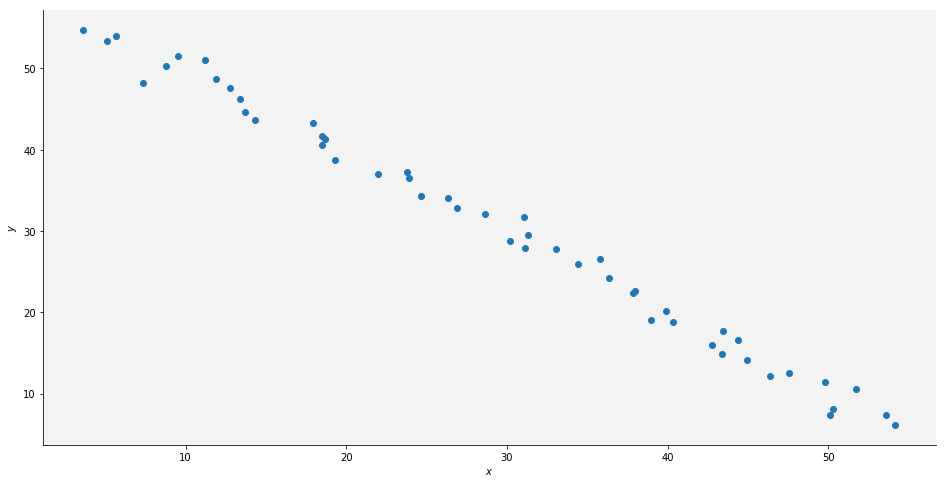

In [87]:
# Some noise to make stuff look fancy
gaussian_noise_x1, gaussian_noise_x2 = np.random.normal(size=(2, 50))
# Explanatory variable
x = np.arange(5, 55) + gaussian_noise_x1
# Target label
y = np.arange(55, 5, -1) + gaussian_noise_x2
plt.figure(figsize=(16, 8))
plt.scatter(x, y)
plt.xlabel("$x$")
plt.ylabel("$y$")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")
pass

I'd say it's quite evident that we can definitely fit a line in here, but how do we do this? We don't really know the mapping that's going on here, although it's quite obvious that we can fit the typical $y = x$ line with minimal error.

We need to define a *loss function*. Suppose we'd like to know a function $\hat{y} = ax + b$, the parameters we need to estimate are $a$ and $b$, which are both scalars. These are sometimes called the weights of our model. $\hat{y}$ is a way to say that this is an estimate. Let's use the most intuitive loss function we have available, which we know as **mean squared error** or MSE. Let's address this in the most naive, most intuitive way possible:

1. A way to measure the error is to know the distance (or difference) between our estimation $\hat{y}$ and the true value $y$ for a given observation $x$. (I'm not using $X$ as it's really just a scalar.) We can write this as $y - \hat{y}$, but this doesn't look right, is there such a thing as a negative distance?
2. Okay, there's no such thing as negative distance, so let's take the absolute value of this, which turns out to be $|y - \hat{y}|$. This is known as the **absolute error**.
3. Although that's quite useful, **squaring** the error, among other properties, **emphasizes** big differences, which turns out to be a good way to punish errors in our algorithm, so now we're using $(y - \hat{y})^2$.
4. Since we've got so many samples, we might as well average this error, which results in the **Mean Squared Error**:

$$
\frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - \hat{y_i})^2
$$

5. We need a way to know how to tune our coefficients in our learning process. This is achieved through the *differentiation* of the cost function with respect to its parameters. Let's expand our terms and find out what we need to derive, though.

$$
\frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - \hat{y_i})^2 = \frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - (ax_i + b))^2
$$

Sometimes they make this a vector called $\theta$ and the cost function is expressed in vector notation as $J(\theta)$, for simplicity, we're just going to make this extremely evident and avoid generalization, our cost function will be defined as:

$$
J(a, b) = \frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - (ax_i + b))^2
$$

6. Finally, derive with respect to both $a$ and $b$, which are our parameters. These are known as the *partial derivatives of our cost function*. Let's be extremely explicit with this as well, just for math's sake.

$$
J(a, b) = \frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - (ax_i + b))^2 = \frac{1}{n}\cdot\sum_{i=1}^{n}(y_i - ax_i - b)^2
$$

$$
\frac{dJ(a,b)}{da} = \frac{1}{n}\cdot\sum_{i=1}^{n}(2 \cdot -x_i(y_i - ax_i - b)) = \frac{1}{n}\cdot\sum_{i=1}^{n}(-2x_i(y_i - ax_i - b)) = \frac{1}{n}\cdot\sum_{i=1}^{n}-2x_i(y_i - (ax_i + b))
$$

$$
\frac{dJ(a,b)}{db} = \frac{1}{n}\cdot\sum_{i=1}^{n}(2 \cdot -(y_i - ax_i - b)) = \frac{1}{n}\cdot\sum_{i=1}^{n}-2 (y_i - (ax_i + b))
$$

Fine, that's a lot of math, let's just say that we now have something called a **gradient**, which indicates the direction of **steepest ascent** of our function, let's represent this gradient in a cooler notation:

$$
\triangledown{J(a,b)} = \begin{bmatrix}\frac{dJ(a,b)}{da} \\ \frac{dJ(a,b)}{db}\end{bmatrix} = \begin{bmatrix}\frac{1}{n}\cdot\sum_{i=1}^{n}-2x_i(y_i - (ax_i + b)) \\\frac{1}{n}\cdot\sum_{i=1}^{n}-2 (y_i - (ax_i + b))\end{bmatrix}
$$

But our cost function optimization method is not called **gradient ascent**, it's called **gradient *descent***, meaning that we need to move in the direction opposite to the gradient!

As such, we're going to use $-\triangledown{J(a,b)}$ to update our coefficients. Do note that the algorithm we're going to use is actually called **batch gradient descent**. It consits of going through all data, calculating our estimations and seeing how far away we're from the true values through the MSE. We use the derivatives above to fine-tune the coefficients $a$ and $b$ in steps defined by the number of iterations that batch gradient descent will run, and afterwards. Actually saying "derivatives" isn't quite correct, what we're actually doing is going in the opposite direction of the *gradient*, multiplied by a pre-defined *learning rate* which allows us to make small steps in the direction that minimizes the error, or MSE.

Let's code this.

In [142]:
# I'm purposefully avoiding vectorization
class SingleVariableLinearRegression:
    
    # Do note that the gradient explodes if the learning rate is 0.01
    def __init__(self, lr=0.0011, iters=100):
        self.lr = lr
        self.iters = iters
        
    def predict(self, x):
        return [self.coeff * x_i - self.bias for x_i in x]
    
    def fit(self, x, y):
        assert len(x) == len(y)
        self.coeff = np.zeros(x.ndim)
        self.bias = np.zeros(1)
        history = []
        for it in range(self.iters):
            y_hat = self.predict(x)
            weight_grad, bias_grad = self.calculate_gradient(x, y, y_hat)
            if it % 20 == 0:
                print("Iteration: {} - MSE: {}".format(it, self.mse(y, y_hat)))
                print("Weight gradient: {} - Bias gradient: {}".format(weight_grad, bias_grad))
                print("Coefficient, Bias: {}, {}".format(self.coeff, self.bias))
            history.append(dict(coeff=self.coeff[0], bias=self.bias[0], mse=self.mse(y, y_hat)))
            # The descent of the gradient!
            self.coeff -= self.lr * weight_grad
            self.bias -= self.lr * bias_grad
        print("Done!")
        print("Final coefficient and bias: a = {}, b = {}".format(self.coeff, self.bias))
        return history
            
    
    def calculate_gradient(self, x, y, y_hat):
        assert len(x) == len(y)
        n = len(x)
        # dJ(a,b)/da
        weight_grad = (1 / n) * sum([(-2 * x_i) * (y_i - y_hat_i) for x_i, y_i, y_hat_i in zip(x, y, y_hat)])
        # dJ(a,b)/db
        bias_grad = (1 / n) * sum([-2 * (y_i - y_hat_i) for x_i, y_i, y_hat_i in zip(x, y, y_hat)])
        return weight_grad, bias_grad
    
    def mse(self, y, y_hat):
        assert len(y) == len(y_hat)
        n = len(y)
        return (1 / n) * sum([(y_i - y_hat_i) ** 2 for y_i, y_hat_i in zip(y, y_hat)])
        

In [143]:
regression_model = SingleVariableLinearRegression()
history = regression_model.fit(x, y)

Iteration: 0 - MSE: [1138.68129872]
Weight gradient: [-1366.59353787] - Bias gradient: [-60.96794296]
Coefficient, Bias: [0.], [0.]
Iteration: 20 - MSE: [1.13685935e+08]
Weight gradient: [-699593.2348813] - Bias gradient: [-19095.55558936]
Coefficient, Bias: [-324.59644634], [-8.32495711]
Iteration: 40 - MSE: [2.98213251e+13]
Weight gradient: [-3.58308135e+08] - Bias gradient: [-9767873.28860805]
Coefficient, Bias: [-166579.44357021], [-4540.0749887]
Iteration: 60 - MSE: [7.82257758e+18]
Weight gradient: [-1.83513551e+11] - Bias gradient: [-5.00276861e+09]
Coefficient, Bias: [-85316809.28531197], [-2325822.59527962]
Iteration: 80 - MSE: [2.05197857e+24]
Weight gradient: [-9.39895584e+13] - Bias gradient: [-2.56225226e+12]
Coefficient, Bias: [-4.36964424e+10], [-1.19121007e+09]
Done!
Final coefficient and bias: a = [-2.23798695e+13], b = [-6.10098317e+11]


Okay, we've got some results, let's check the fit.

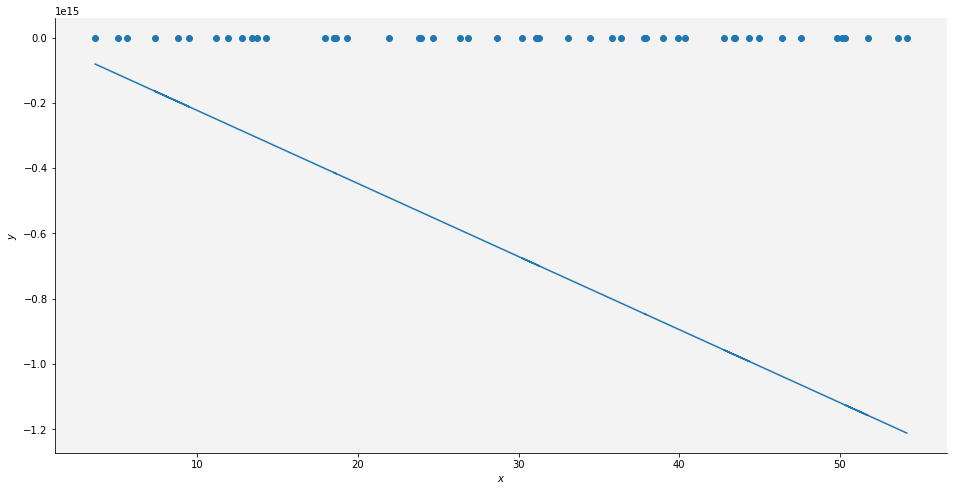

In [144]:
plt.figure(figsize=(16, 8))
plt.scatter(x, y)
plt.xlabel("$x$")
plt.ylabel("$y$")
y_hat = regression_model.predict(x)
plt.plot(x, y_hat)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")

That's a very nice looking fit, let's see the process the Linear Regression went through:

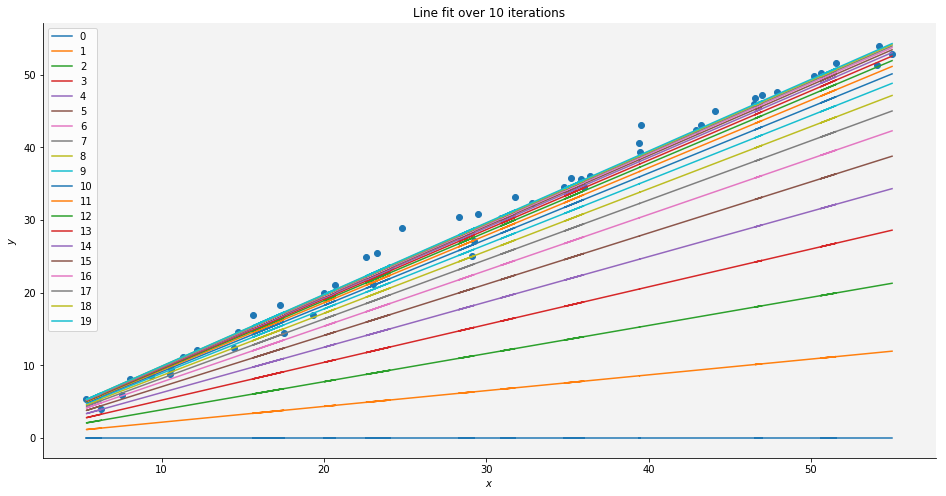

In [72]:
plt.figure(figsize=(16, 8))
for i, hist in enumerate(history[:20]):
    plt.plot(x, hist["coeff"] * x + hist["bias"], label=i)
    plt.legend()
plt.scatter(x, y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Line fit over 10 iterations")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")
pass

In [80]:
history

[{'coeff': 0.0, 'bias': 0.0, 'mse': array([0.52])},
 {'coeff': 0.0043342644188468955,
  'bias': 0.00010400000000000001,
  'mse': array([0.35272739])},
 {'coeff': 0.007722991316766932,
  'bias': 0.00018235240494047573,
  'mse': array([0.25047235])},
 {'coeff': 0.010372436046385956,
  'bias': 0.00024065175073242863,
  'mse': array([0.18796334])},
 {'coeff': 0.012443862333664986,
  'bias': 0.0002832722060633576,
  'mse': array([0.14975154])},
 {'coeff': 0.01406335655153807,
  'bias': 0.0003136337778838786,
  'mse': array([0.12639293])},
 {'coeff': 0.015329501151482867,
  'bias': 0.0003344104480116815,
  'mse': array([0.11211424])},
 {'coeff': 0.01631937424680529,
  'bias': 0.0003476929077410121,
  'mse': array([0.10338623])},
 {'coeff': 0.01709324047346991,
  'bias': 0.0003551157942471274,
  'mse': array([0.0980514])},
 {'coeff': 0.017698218607380422,
  'bias': 0.000357957172206526,
  'mse': array([0.09479088])},
 {'coeff': 0.018171149143914,
  'bias': 0.00035721631493832823,
  'mse': arr

It almost looks like it's bouncing, isn't it? This is due to the *learning rate*, which may be high enough that the gradient misses the minima of the cost function it's optimizing.

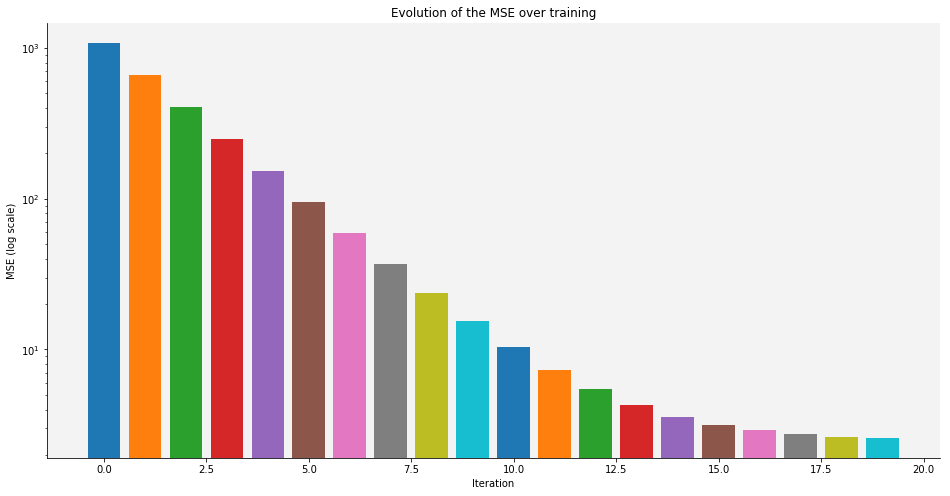

In [73]:
plt.figure(figsize=(16, 8))
for i, hist in enumerate(history[:100]):
    plt.bar(i, hist["mse"])
plt.title("Evolution of the MSE over training")
plt.xlabel("Iteration")
plt.ylabel("MSE (log scale)")
plt.yscale("log")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")
pass

## Moving on to Logistic Regression

*Linear Regression* seeks to predict a continuos variable through explanatory variables. *Logistic Regression*, on the other hand, seeks to assign the *likeliest categorical value* from a given set of categories, also known as a *class*. We'll focus on binary classification, where we only have two classes: **Positive** and **Negative**.

In mathy terms, we say that $y \in [0, 1] \: s.t \: 0 \: is \: a \: negative \: case \:,and \: 1 \: is \: a \: positive\: case$.

Intuitively, the problem of classifying a problem with labels is not that different from a linear regression. Let's change our labels from the previous problem, while keeping them linearly separable. We'll talk about non-linearity later.

In [74]:
m = np.mean(y)
y = (y >= m).astype("int")

In [75]:
neg = [(x_, y_) for x_, y_ in zip(x, y) if y_ == 0]
pos = [(x_, y_) for x_, y_ in zip(x, y) if y_ == 1]
x_0 = [x[0] for x in neg]
y_0 = [x[1] for x in neg]
x_1 = [x[0] for x in pos]
y_1 = [x[1] for x in pos]

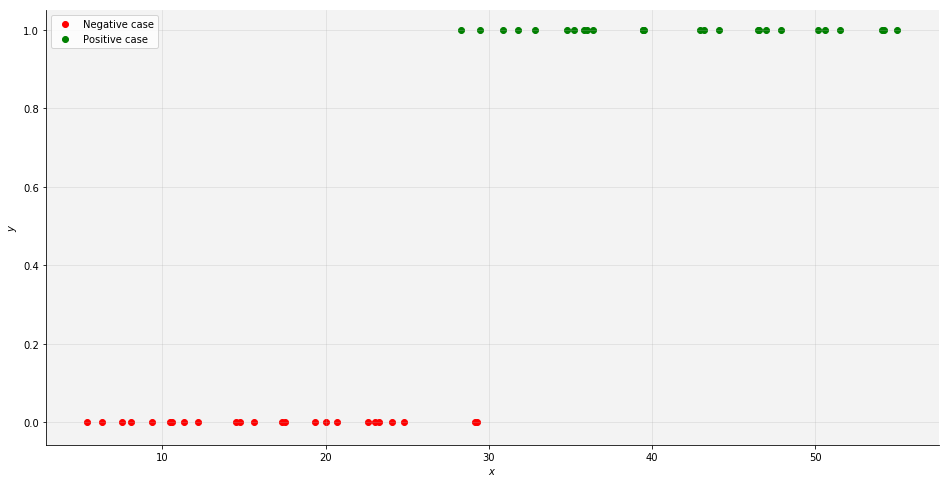

In [76]:
plt.figure(figsize=(16, 8))
plt.scatter(x_0, y_0, c="red", label="Negative case")
plt.scatter(x_1, y_1, c="green", label="Positive case")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(alpha=0.3)
plt.legend()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")

So now what we're doing is a bit different. We're not trying to fit a line to our data to best capture tendencies, but rather, we're trying to create the best possible **separator** between our two categories. We can actually use **Mean Squared Error** for this, which will give us back something akin to a probability of a sample belonging to a certain class. Let's try it out.

In [77]:
mse_classifier = SingleVariableLinearRegression()
history = mse_classifier.fit(x, y)

Iteration: 0 - MSE: [0.52]
Weight gradient: [-43.34264419] - Bias gradient: [-1.04]
Coefficient, Bias: [0.], [0.]
Done!
Final coefficient and bias: a = [0.01971908], b = [0.00026349]


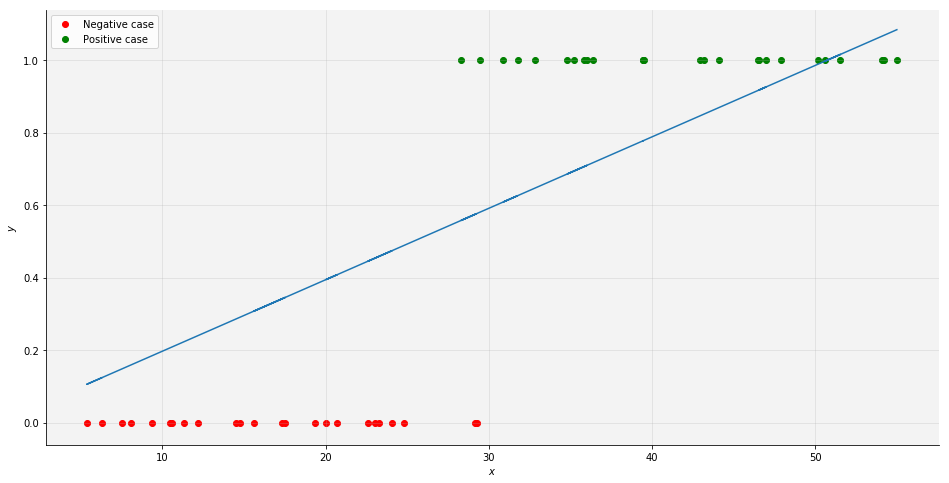

In [78]:
plt.figure(figsize=(16, 8))
plt.scatter(x_0, y_0, c="red", label="Negative case")
plt.scatter(x_1, y_1, c="green", label="Positive case")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(alpha=0.3)
plt.legend()
y_hat = mse_classifier.predict(x)
plt.plot(x, y_hat)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("#f3f3f3")